### This notebook implements :
1. Squeezing input curve to 5 values.
1. Perceptron fitting on data of 4 component task with squeezed input data.
2. KAN fitting on data of 4 component task with squeezed input data.
4. Transformation KAN model to expression analytic functions expression.

---
Functions, that are used in this notebook, are written in modules:
* raw_data_processing.py
* tools.py

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy, copy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from kan import KAN

from tqdm import tqdm

In [2]:
from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter, KAN_es

In [3]:
SCRIPT_DIR = os.path.abspath('')

## Loading data

In [4]:
d_config = JSON_Read("", "json_config.txt")
d_config

{'SPEC_FOLDER': 'full_data',
 'EXCITE_WAVE_LENGTH': 350,
 'PREDICT_IONS': ['Cr'],
 'TRAIN_TEST_RATIO': 0.9,
 'VALIDATION_TRAIN_RATIO': 0.222,
 'RANDOM_STATE_SPLIT': 42,
 'N_ITER_NO_CHANGE': 100,
 'HIDDEN_LAYER_SIZES': 64,
 'RANDOM_STATE_TRAIN': 42,
 'ACTIVATION': 'tanh',
 'SOLVER': 'adam',
 'EARLY_STOPPING': True,
 'MAX_ITER': 10000,
 'TOL': 0.001}

In [5]:
EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = ['Cr']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE']

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']
MAX_ITER = d_config['MAX_ITER']

In [6]:
VALIDATION_TRAIN_RATIO

0.222

In [7]:
PREDICT_IONS

['Cr']

In [8]:
x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

In [9]:
x

,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,...,741.0,742.0,743.0,744.0,745.0,746.0,747.0,748.0,749.0,750.0
1,2.358,2.249,0.788,2.067,2.199,0.732,1.025,1.716,1.537,0.052,...,2.829,2.543,2.694,3.451,2.910,3.381,3.153,2.326,3.439,3.443
2,5.769,3.680,4.350,5.620,3.090,4.872,3.121,4.202,3.247,2.855,...,3.710,6.719,4.194,4.926,5.587,4.855,5.233,5.584,6.135,7.171
3,2.037,1.928,2.309,2.725,1.803,1.677,1.977,1.857,2.106,1.375,...,3.709,4.711,4.647,5.305,5.232,5.473,5.337,2.666,4.993,3.228
4,3.075,2.551,1.681,1.908,2.565,2.419,2.323,2.013,1.767,2.648,...,5.002,4.668,3.596,4.468,2.947,5.330,3.648,4.799,4.234,4.523
5,1.423,2.238,2.101,2.561,1.994,1.808,1.691,1.662,2.191,1.002,...,5.019,3.541,4.198,5.146,5.086,4.007,5.724,5.749,3.717,4.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4.932,2.551,2.051,2.668,1.659,2.705,2.637,1.642,2.294,2.138,...,4.665,3.308,3.899,2.836,3.634,3.602,4.800,4.638,3.036,5.293
997,4.008,3.593,2.359,2.731,2.395,2.859,1.878,2.170,2.887,0.898,...,3.452,4.428,3.616,4.664,4.877,4.359,5.153,3.957,4.406,4.507
998,3.214,2.987,3.374,3.145,2.788,2.231,2.414,1.673,2.372,2.171,...,3.111,3.621,3.163,3.341,4.779,3.578,6.185,3.565,4.193,4.088
999,3.257,2.987,3.121,3.626,1.442,3.501,1.814,2.174,1.252,1.788,...,3.904,3.065,3.455,3.551,3.164,4.492,4.171,3.796,5.633,4.440


In [10]:
y

array([0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65,
       2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 ,
       2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75,
       3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 ,
       3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85,
       4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 ,
       4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95,
       0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.

# Squeeze input data

In [11]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)

## Creating new inputs
As squeezed input data we will use:
1. $I$: Maximum intensity value 
2. $c$: Position of maximum intensity
3. $c_h$ : Center position intensity curve on I/2 intensity
4. $wth$ : Width of intensity curve on I/2 intensity
5. $rat$ : Ratio of area under intensity curve on the right from c and on the left from

In [12]:
def get_sqz_input(x_axis, y_axis):
    ''' Evaluate squeezed data from curve.
    '''
    i_max = np.argmax(y_axis)
    I = y_axis[i_max]  # Max I
    c_I = x_axis[i_max]  # Coordinate of max I

    diff_I = np.absolute(y_axis-I/2)
    c_I2_left = x_axis[ np.argmin(diff_I[:i_max]) ]  # Left I/2 coordinate
    c_I2_right = x_axis[ np.argmin(diff_I[i_max:])+i_max]  # Right I/2 coordinate

    c_I2 = np.mean([c_I2_left, c_I2_right])  # Mean center coordinate on I/2 
    disp_I2 = np.abs(c_I2_right-c_I2_left)  # Width of curve on I/2 y-level

    integr_ratio = np.sum(y_axis[i_max+1:]) / np.sum(y_axis[:i_max])

    sqz_input = [I, c_I, c_I2, disp_I2, integr_ratio]
    
    
    return sqz_input

In [13]:
x_axis, y_axis = l_wavelenth, x.loc[x.index[0]].values

get_sqz_input(x_axis, y_axis)

[903.693, 442.0, 448.0, 74.0, 1.675796089555411]

In [14]:
y

array([0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65,
       2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 ,
       2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75,
       3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 ,
       3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85,
       4.4 , 4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 ,
       4.95, 0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95,
       0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  ,
       0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55,
       1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.  , 0.55, 1.1 ,
       1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 0.

In [15]:
def get_all_sqz_input(matr_x, matr_y):
    matr_sqz_input = []
    for x_axis, y_axis in zip(matr_x, matr_y):
        matr_sqz_input.append(get_sqz_input(x_axis, y_axis))


    return np.array(matr_sqz_input)

In [16]:
x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()

x = get_all_sqz_input(x_matrix, y_matrix)

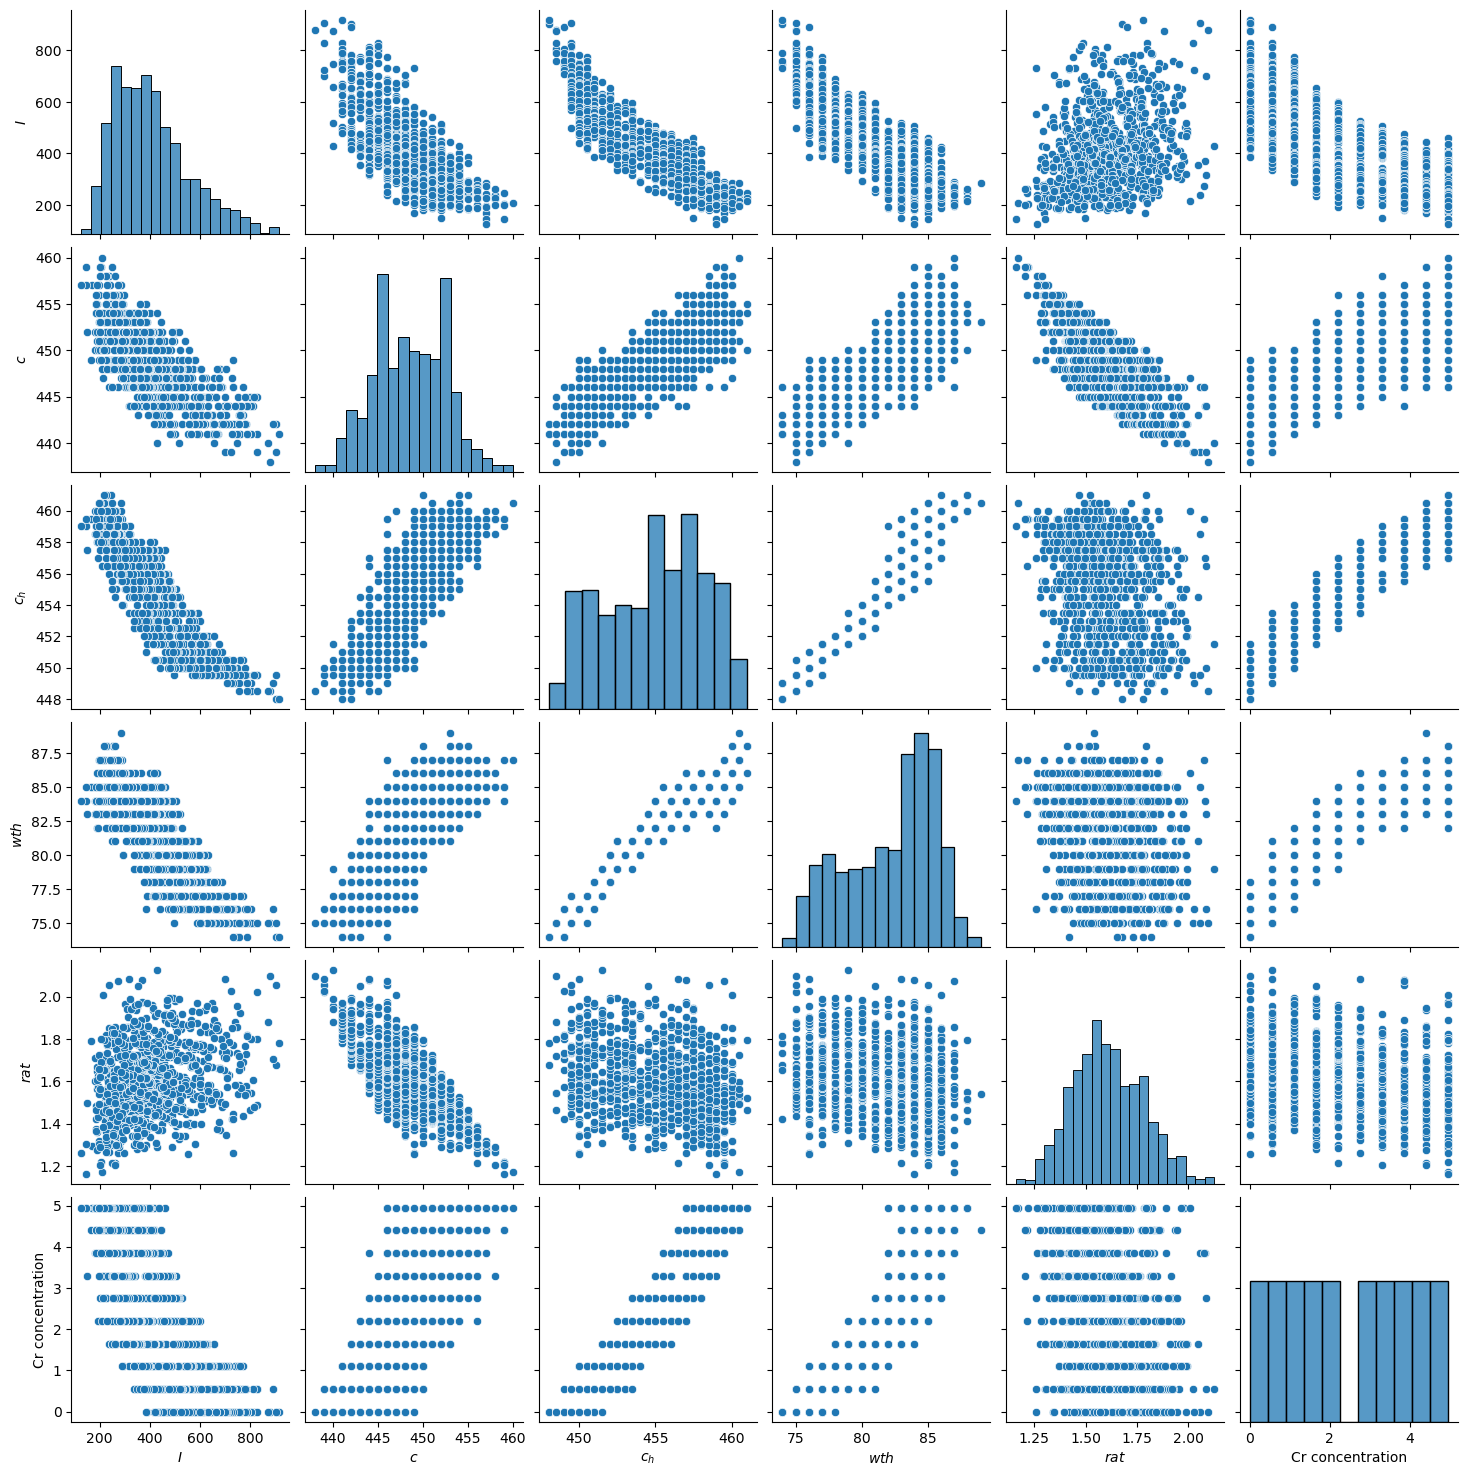

In [107]:
import seaborn as sns
squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
sns.pairplot(squeezed_df)

In [88]:
y.reshape([-1,1]).shape

(1000, 1)

## Scaling data
Train / Validation / Test = 0.7 / 0.2 / 0.1

TRAIN_TEST_RATIO = (Train+Validation) / (Train+Validation+Test)

VALIDATION_TRAIN_RATIO = Validation / (Train+Validation)

In [49]:
TRAIN_TEST_RATIO

0.9

In [50]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

In [51]:
x_train.shape, x_test.shape

((900, 5), (100, 5))

In [52]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Model - MLP

Ordinary one-hidden-layer with 5 neurons perceptron.
We use MLPRegressor from scikit-learn library.

In [22]:
model = MLPRegressor(hidden_layer_sizes=64,#HIDDEN_LAYER_SIZES,
                     activation=ACTIVATION,
                     solver=SOLVER,
                     early_stopping=True,
                     validation_fraction=VALIDATION_TRAIN_RATIO,
                     n_iter_no_change=N_ITER_NO_CHANGE,
                     learning_rate_init = 0.001,
                     learning_rate='adaptive',
                     max_iter=10000,#MAX_ITER,
                     random_state=1,
                     tol=0.001)

In [23]:
model.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 64,
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 10000,
 'momentum': 0.9,
 'n_iter_no_change': 100,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.001,
 'validation_fraction': 0.222,
 'verbose': False,
 'warm_start': False}

In [24]:
# Обучение модели на тренировочных данных
model.fit(x_train, y_train)

MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=64,
             learning_rate='adaptive', max_iter=10000, n_iter_no_change=100,
             random_state=1, tol=0.001, validation_fraction=0.222)

In [25]:
def scatter_prediction(model, 
                       x, 
                       y_true, 
                       title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

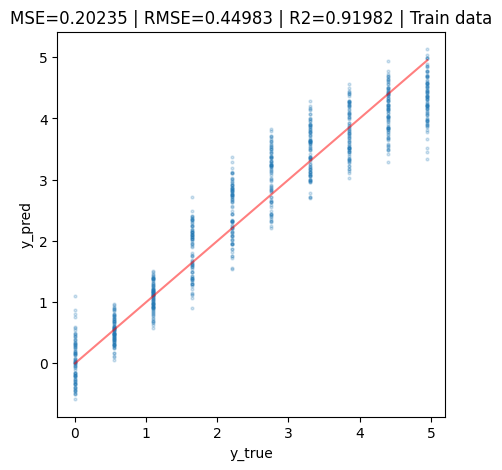

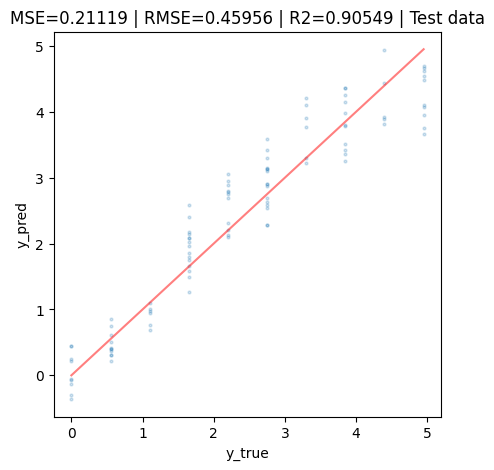

(0.2111942302388789, 0.9054940447253692)

In [26]:
scatter_prediction(model, x_train, y_train, "Train data")
scatter_prediction(model, x_test, y_test, "Test data")

## KAN

New ML architecture, alternative to neural networks. Relies on the Kolmagprov-Arnold theorem about decomposition of function with many parameters:
$$ f(x_{1},\cdot\cdot\cdot, x_{n})\sum_{q=1}^{2n+1}\Phi_{q}(\sum_{p=1}^{n}\varphi_{q,p}(x_{p})) $$

The main idea - represent $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ as a B-splines, and optimize their parameters during training.
After training it is possible to fit $\Phi_{q}(\cdot)$ and $\varphi_{q,p}(\cdot)$ by analytic formulas, post-train and express received KAN model as regular expression with analytic functions.


Some hyperparameteres of KANs (not all):
- grid: Number of grid intervals. 

Each function in KAN is represented in B-splines - in other words sum of polynoms, located on certain area of input parametere. Grid defines number of training parameteres and complexity of model. Number of grids can be gradually increased during training KAN - provided in "Gradially increasing grid" section.

- k: Order of piecewise polynomial in B-splines. k=3 provides smooth small order polynoms.

In [22]:
def scatter_prediction_kan(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.forward(x).detach().numpy()
    y_true = y_true.detach().numpy()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

In [54]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

tc_x_train = torch.tensor(x_train, dtype=torch.float)
tc_y_train = torch.tensor(y_train.reshape([-1,1]), dtype=torch.float)
tc_x_test = torch.tensor(x_test, dtype=torch.float)
tc_y_test = torch.tensor(y_test.reshape([-1,1]), dtype=torch.float)

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

In [55]:
# Some constants
K = 3 # order of piecewise polynomial in B-splines
INPUT_SHAPE = tc_x_test.shape[1]

In [56]:
INPUT_SHAPE

5

## Grid = 3 | hidden neurons = 1

checkpoint directory created: ./model
saving model version 0.0


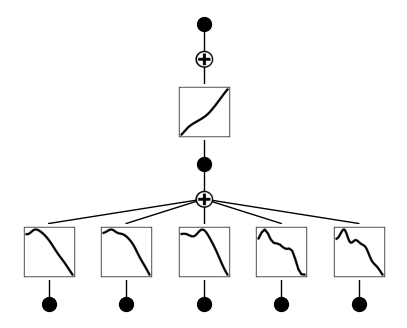

In [57]:
model1 = KAN(width=[INPUT_SHAPE, 1, 1], grid=3, k=K)

model1(dataset['train_input'])
model1.plot(beta=100)


In [58]:
model_cp = copy(model1)

loss_fn = lambda x, y: torch.mean((x - y) ** 2)
loss_fn(model_cp(dataset['test_input']), dataset['test_label']).cpu().detach().numpy()**0.5

3.1159275

In [59]:
result1 = model1.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=0,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 3.25e-01 | test_loss: 4.09e-01 | reg: 9.82e+00 | : 100%|█| 20/20 [00:04<00:00,  4.26it

saving model version 0.1


In [60]:
loss_fn(model_cp(dataset['test_input']), dataset['test_label']).cpu().detach().numpy()**0.5

0.40945128

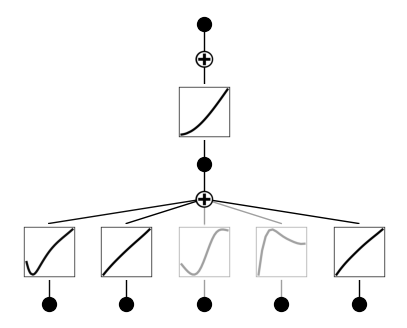

In [61]:
model1.plot()

Text(0.5, 0, 'step')

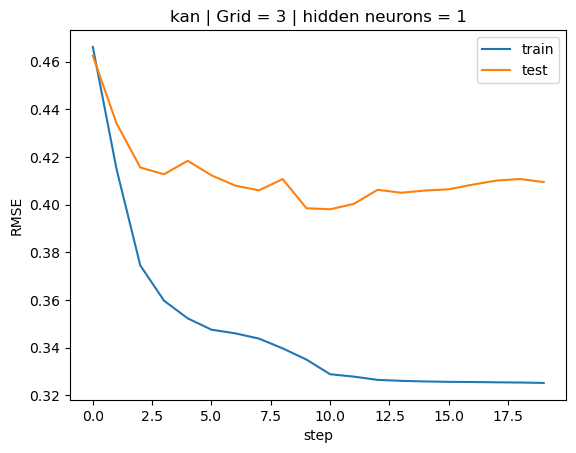

In [62]:
plt.plot(result1['train_loss'])
plt.plot(result1['test_loss'])
#plt.plot(result1['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')

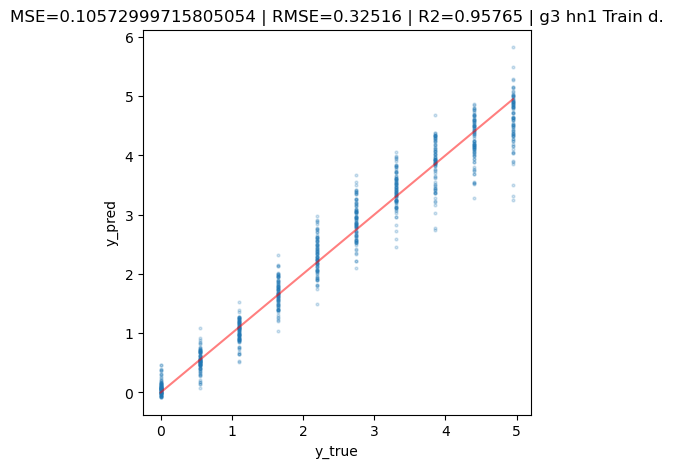

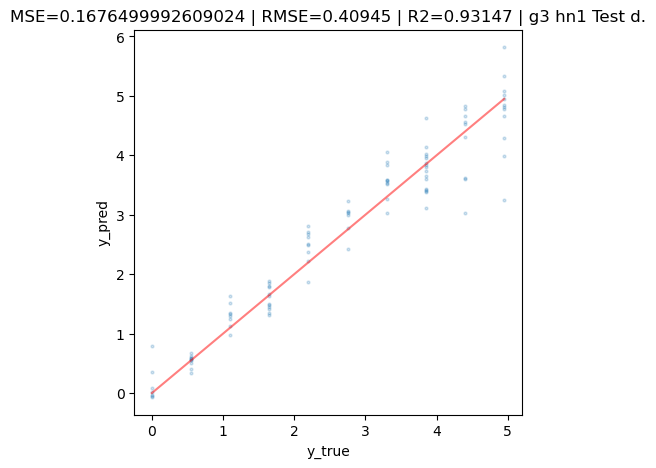

(0.16765036, 0.9314725399017334)

In [63]:
scatter_prediction_kan(model1, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1, tc_x_test, tc_y_test, "g3 hn1 Test d.")

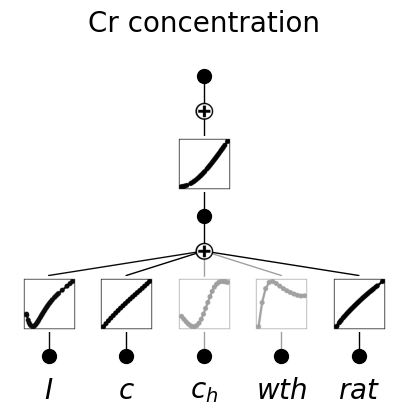

In [64]:
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }

model1.plot(**prnt_kwrgs)

saving model version 0.2


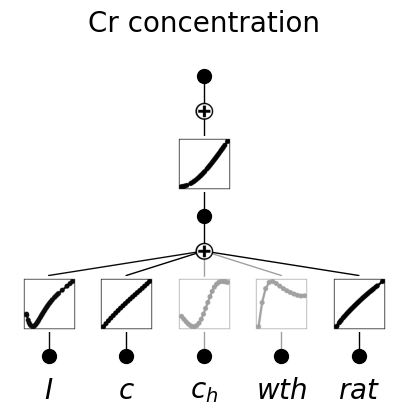

In [65]:
model1.prune()
model1.plot(**prnt_kwrgs)

saving model version 0.2


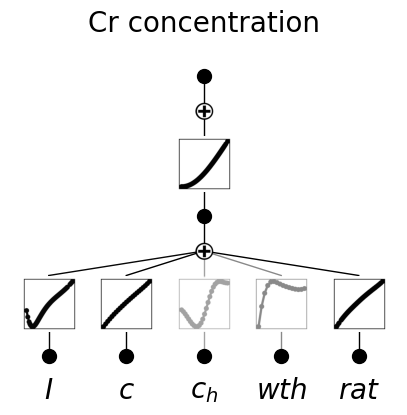

In [66]:
model1_sym = model1.prune()

model1_sym(dataset['train_input']) # it's important to do a forward first to collect activations
model1_sym.plot(**prnt_kwrgs)

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1      cos    0.993737 -7.316721           2                2    0.136656
2      sin    0.993737 -7.316721           2                2    0.136656
3        x    0.802811 -2.342277           1                1    0.331545
4      x^2    0.860871 -2.845403           2                2    1.030919


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 0.0,
 0)

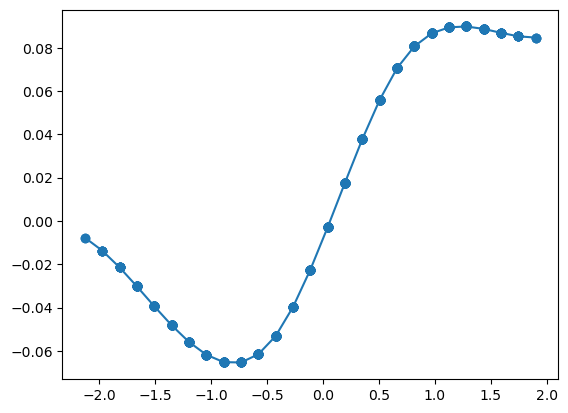

In [67]:
l = 0#1
i = 2#0
j = 0#0

inputs = model1_sym.spline_preacts[l][:,j,i]
outputs = model1_sym.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

model1_sym.suggest_symbolic(l,i,j)

In [68]:
# now let's replace every activation function with its top 1 symbolic suggestion. This is implmented in auto_symbolic()
model1_sym.auto_symbolic()

# if the user wants to constrain the symbolic space, they can pass in their symbolic libarary
# lib = ['sin', 'x^2', 'exp']
# model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.9707887172698975, c=1
fixing (0,1,0) with x^0.5, r2=0.9998974204063416, c=2
fixing (0,2,0) with 0, r2=0.0, c=0
fixing (0,3,0) with 0, r2=0.0, c=0
fixing (0,4,0) with x^0.5, r2=0.9999390840530396, c=2
fixing (1,0,0) with cos, r2=0.9999975562095642, c=2
saving model version 0.3


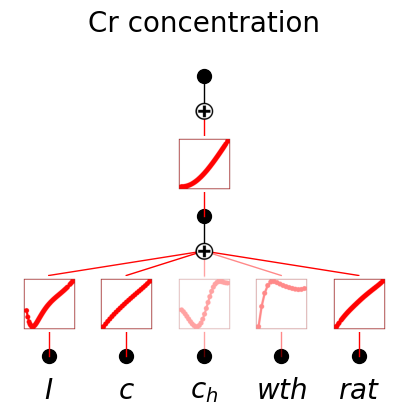

In [69]:
model1_sym.plot(**prnt_kwrgs)

| train_loss: 4.02e-01 | test_loss: 4.84e-01 | reg: 0.00e+00 | : 100%|█| 20/20 [00:03<00:00,  5.37it


saving model version 0.4


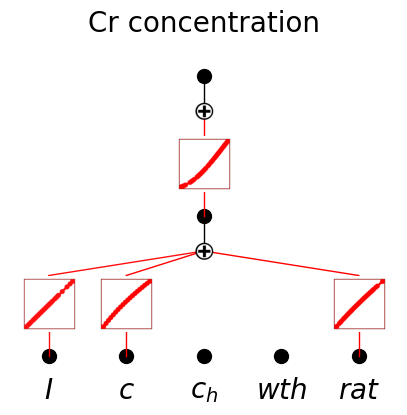

In [71]:
model1_sym.fit(dataset, opt="LBFGS", steps=20)
model1_sym.plot(**prnt_kwrgs)

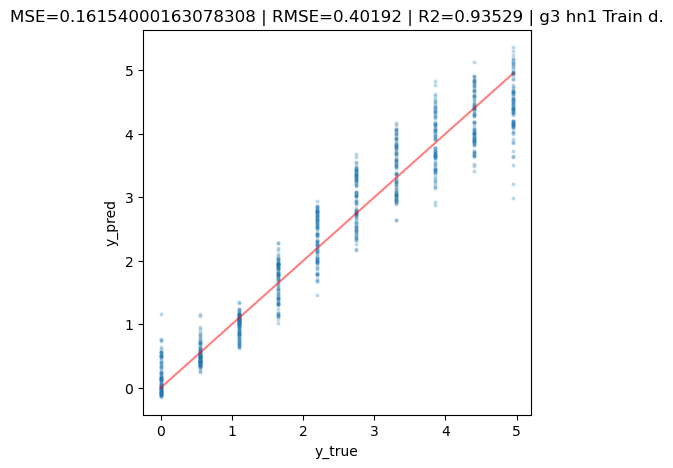

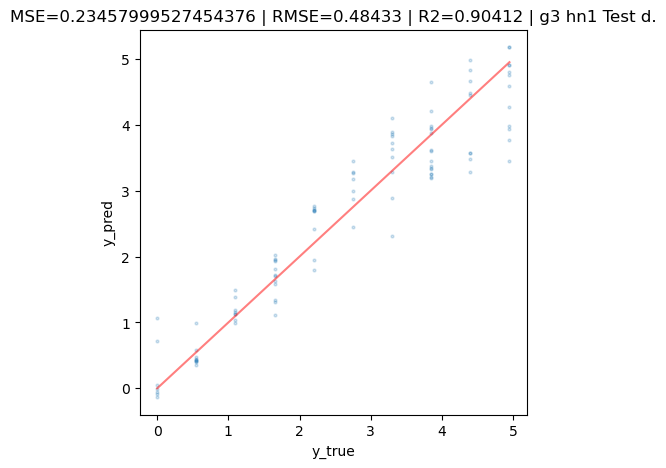

(0.23457827, 0.9041155576705933)

In [73]:
scatter_prediction_kan(model1_sym, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1_sym, tc_x_test, tc_y_test, "g3 hn1 Test d.")

In [72]:
# obtaining symbolic formula
formula, variables  = model1_sym.symbolic_formula(var=['I', 'c', 'c_h', 'wth', 'rat'])
formula[0]

4.4724555015564 - 4.76643991470337*cos(0.255492023901759*I + 7.80513192974439*sqrt(0.219259120054577*c + 1) + 9.2547978544412*sqrt(0.105846187075296*rat + 1) - 9.623346593015)

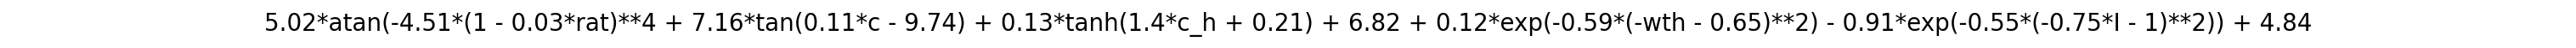

In [352]:
### Создание области отрисовки
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_axis_off()

### Отрисовка формулы
t = ax.text(0.5, 0.5, formula[0],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='black')
        


# Установка размеров области отрисовки
fig.set_size_inches(bbox.width/80,bbox.height/80) # dpi=80

plt.show()

## KAN with early stopping

In [24]:
VALIDATION_TRAIN_RATIO

0.222

In [25]:
RS = None

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=RS)

x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, 
                                                  train_size=VALIDATION_TRAIN_RATIO, 
                                                  random_state=RS)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

tc_x_train = torch.from_numpy(x_train)
tc_y_train = torch.from_numpy(y_train.reshape([-1,1]))
tc_x_val = torch.from_numpy(x_val)
tc_y_val = torch.from_numpy(y_val).reshape([-1,1])
tc_x_test = torch.from_numpy(x_test)
tc_y_test = torch.from_numpy(y_test).reshape([-1,1])

dataset_3 = {'train_input': tc_x_train,
             'train_label': tc_y_train,
             'val_input': tc_x_val,
             'val_label': tc_y_val,
             'test_input': tc_x_test,
             'test_label': tc_y_test}

In [27]:
tc_x_train.shape, tc_x_val.shape, tc_x_test.shape

(torch.Size([701, 5]), torch.Size([199, 5]), torch.Size([100, 5]))

In [28]:
# Some constants
K = 3 # order of piecewise polynomial in B-splines
INPUT_SHAPE = tc_x_test.shape[1]

trn_ls: 3.05e-01 | vl_ls: 3.65e-01 | e_stop: 10/10 | tst_ls: 3.90e-01 | reg: 5.79e+00 :  11%|▍   | 22/200 [00:07<01:02,  2.83it/s]

Early stopping criteria raised


Text(0.5, 0, 'step')

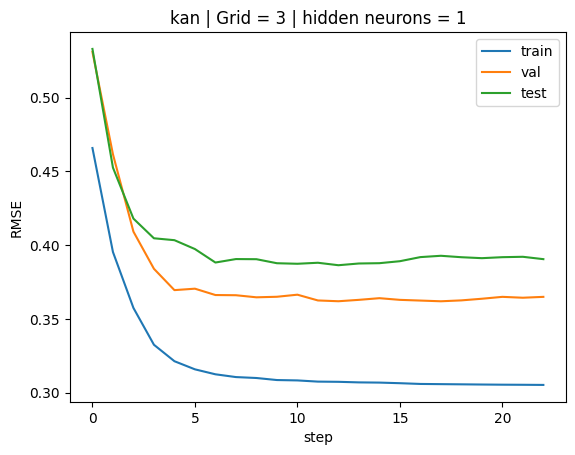

In [29]:
model_es = KAN_es(width=[INPUT_SHAPE, 1, 1], grid=3, k=K)

result_es = model_es.train_es(dataset_3, 
                              tol=0.0001, 
                              n_iter_no_change=10,
                              opt="LBFGS", steps=200, 
                              lamb=0,
                              lamb_l1=1,
                              lamb_entropy=2
                              )

plt.plot(result_es['train_loss'])
plt.plot(result_es['val_loss'])
plt.plot(result_es['test_loss'])

#plt.plot(result1['reg'])
plt.legend(['train', 'val',  'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')

In [30]:
plotly_multi_scatter([(list(range(len(result_es['train_loss']))), result_es['train_loss']),
                      (list(range(len(result_es['val_loss']))), result_es['val_loss']),
                      (list(range(len(result_es['test_loss']))), result_es['test_loss'])],
                      names = ['train_loss', 'val_loss', 'test_loss'],
                      main_title="kan | Grid = 3 | hidden neurons = 1", x_title="step", y_title="RMSE")

[0, 1, 2, 3, 4] [array(0.4657713), array(0.39528221), array(0.35735464), array(0.3324015), array(0.32124632)]
[0, 1, 2, 3, 4] [array(0.53087011), array(0.46153769), array(0.40907986), array(0.38390004), array(0.36943602)]
[0, 1, 2, 3, 4] [array(0.53294106), array(0.45247277), array(0.41790656), array(0.4045772), array(0.40329466)]


In [31]:
input_111 = 'val'

loss_fn = lambda x, y: torch.mean((x - y) ** 2)
loss_fn(model_es(dataset_3[input_111+'_input']), dataset_3[input_111+'_label']).cpu().detach().numpy()**0.5

0.36187538002871866

In [25]:
#result_es['val_loss']
#input_111 = 'val'

#np.sqrt(np.mean( ((model_es(dataset_3[input_111+'_input']) - dataset_3[input_111+'_label'])**2).cpu().detach().numpy() ))
#model_es(dataset_3[input_111+'_input']).cpu().detach().numpy().ravel()

0.31661519672415145

-----
# Exploration code (main results are presented upper)

### Gradially increasing grid

In [184]:
width = [INPUT_SHAPE, 1, 1]
grids = np.array([3, 5, 7, 10])

train_losses = []
test_losses = []
steps = 10

for i in range(grids.shape[0]):
    if i == 0:
        model1_10 = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model1_10 = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model1_10, dataset['train_input'])
    results = model1_10.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

train loss: 3.25e-01 | test loss: 4.06e-01 | reg: 5.84e+00 : 100%|██| 10/10 [00:03<00:00,  3.00it/s]
train loss: 3.18e-01 | test loss: 3.97e-01 | reg: 6.19e+00 : 100%|██| 10/10 [00:03<00:00,  2.74it/s]
train loss: 3.04e-01 | test loss: 4.19e-01 | reg: 5.83e+00 : 100%|██| 10/10 [00:05<00:00,  1.97it/s]
train loss: 2.95e-01 | test loss: 4.26e-01 | reg: 5.76e+00 : 100%|██| 10/10 [00:07<00:00,  1.39it/s]


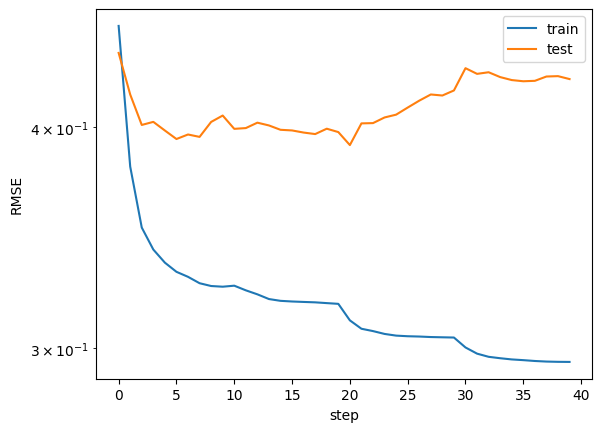

In [185]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

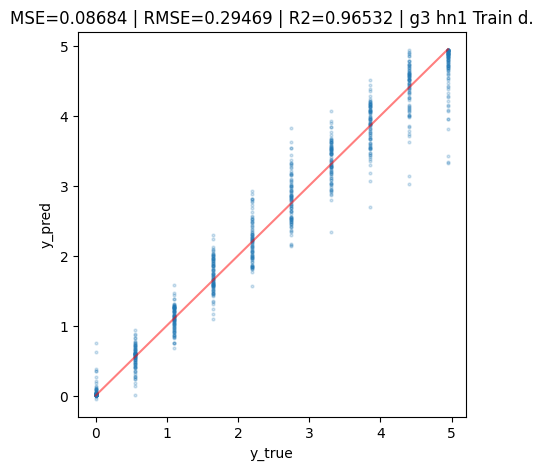

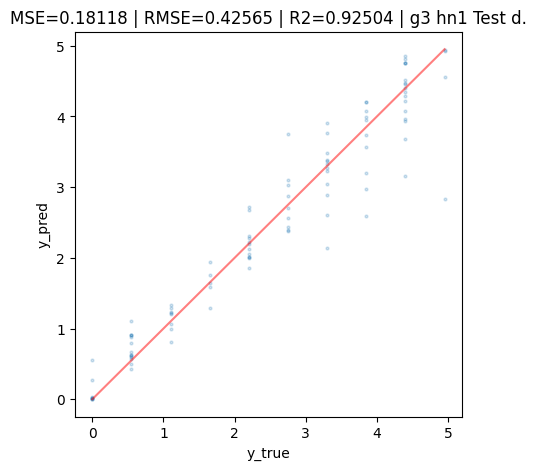

(0.1811777917904237, 0.925035690285626)

In [ ]:
scatter_prediction_kan(model1_10, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model1_10, tc_x_test, tc_y_test, "g3 hn1 Test d.")

## Grid = 3 | hidden neurons = 2

In [187]:
model2 = KAN(width=[INPUT_SHAPE, 2, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [188]:
result2 = model2.train(dataset, opt="LBFGS", steps=20)

train loss: 2.95e-01 | test loss: 4.02e-01 | reg: 8.82e+00 : 100%|██| 20/20 [00:16<00:00,  1.20it/s]


Text(0.5, 0, 'step')

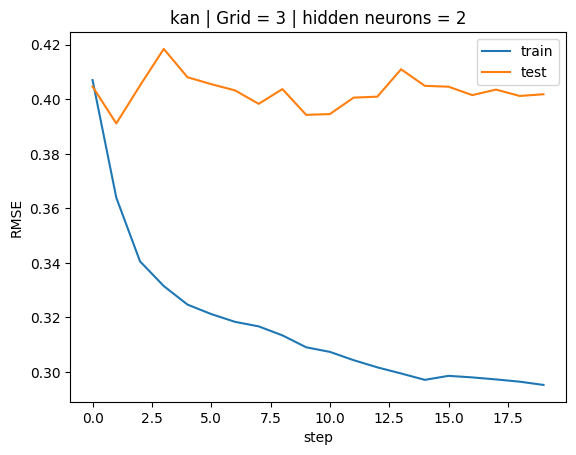

In [189]:
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 3 | hidden neurons = 2')
plt.ylabel('RMSE')
plt.xlabel('step')

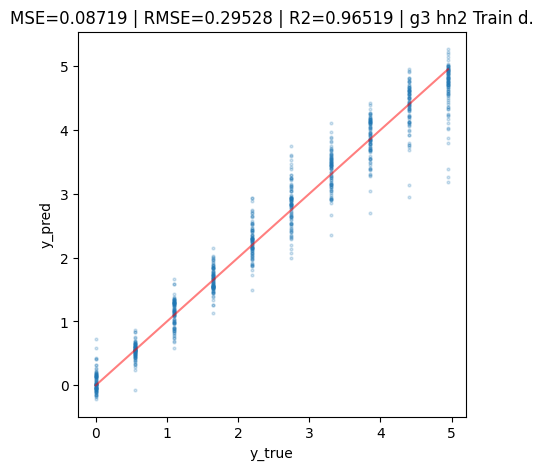

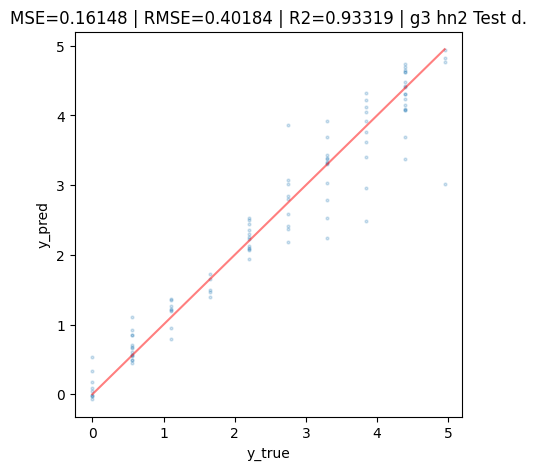

(0.16147653833990702, 0.9331873012023453)

In [190]:
scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn2 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn2 Test d.")

## Grid = 3 | hidden neurons = 5

In [191]:
model5 = KAN(width=[INPUT_SHAPE, 5, 1], grid=3, k=K)
'''
model(dataset['train_input'])
model.plot(beta=100)
'''

"\nmodel(dataset['train_input'])\nmodel.plot(beta=100)\n"

In [192]:
result5 = model5.train(dataset, opt="LBFGS", steps=20)

train loss: 2.84e-01 | test loss: 4.14e-01 | reg: 1.69e+01 : 100%|██| 20/20 [00:30<00:00,  1.52s/it]


Text(0.5, 0, 'step')

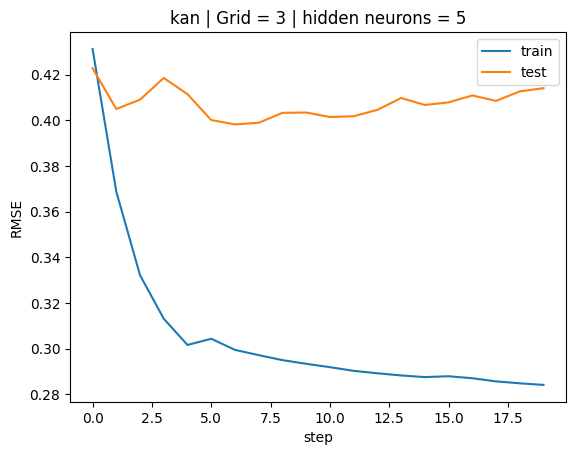

In [193]:
plt.plot(result5['train_loss'])
plt.plot(result5['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 3 | hidden neurons = 5')
plt.ylabel('RMSE')
plt.xlabel('step')

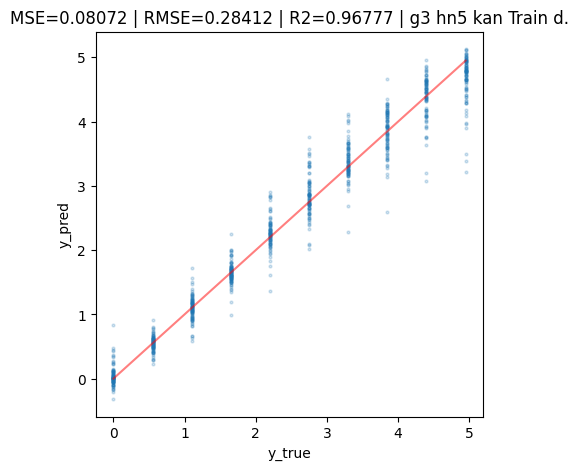

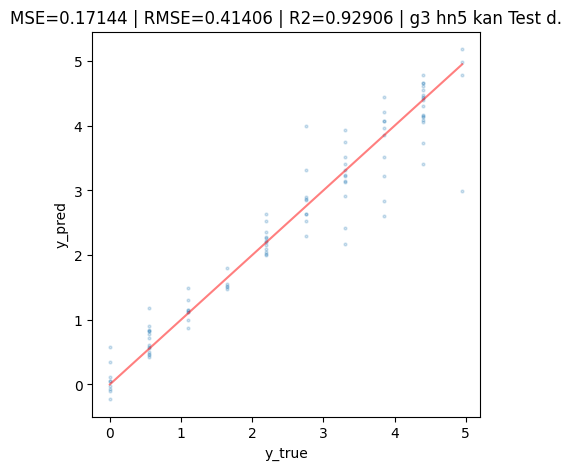

(0.17144472597753835, 0.9290628536198139)

In [194]:
scatter_prediction_kan(model5, tc_x_train, tc_y_train, "g3 hn5 kan Train d.")
scatter_prediction_kan(model5, tc_x_test, tc_y_test, "g3 hn5 kan Test d.")

## Grid=10 | hidden neurons = 5

In [195]:
model5_10 = KAN(width=[INPUT_SHAPE, 5, 1], grid=10, k=K)

result5_10 = model5_10.train(dataset, opt="LBFGS", steps=20)

train loss: 2.19e-01 | test loss: 4.84e-01 | reg: 1.51e+01 : 100%|██| 20/20 [00:37<00:00,  1.88s/it]


Text(0.5, 0, 'step')

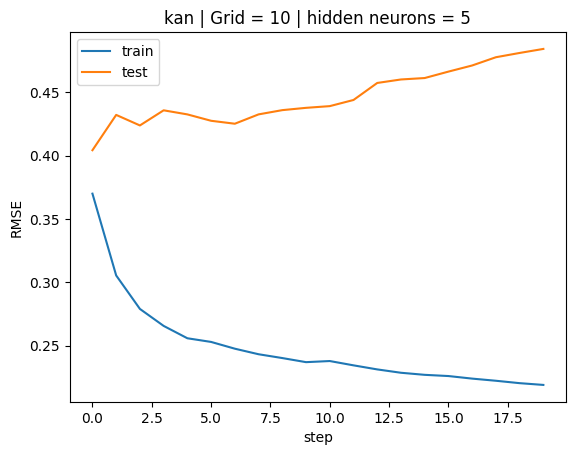

In [196]:
plt.plot(result5_10['train_loss'])
plt.plot(result5_10['test_loss'])
plt.legend(['train', 'test'])
plt.title('kan | Grid = 10 | hidden neurons = 5')
plt.ylabel('RMSE')
plt.xlabel('step')
#plt.yscale('log')

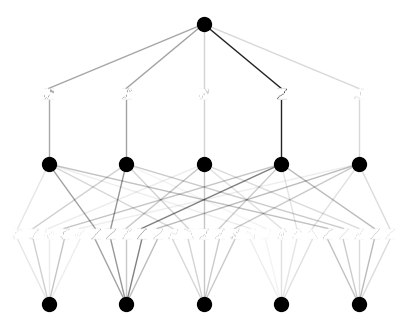

In [197]:
model5_10.plot(beta=3)

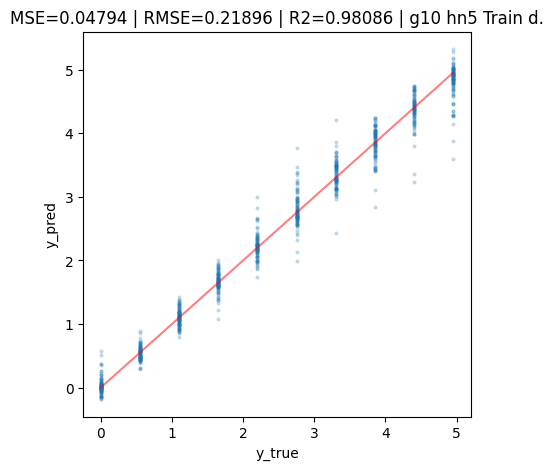

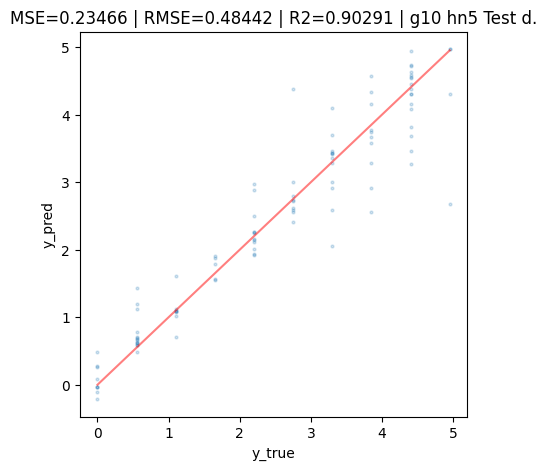

(0.23466218924716967, 0.902905930913837)

In [198]:
scatter_prediction_kan(model5_10, tc_x_train, tc_y_train, "g10 hn5 Train d.")
scatter_prediction_kan(model5_10, tc_x_test, tc_y_test, "g10 hn5 Test d.")

### Gradially increasing grid

In [199]:
width = [INPUT_SHAPE, 5, 1]
grids = np.array([3, 5, 7, 10])

train_losses = []
test_losses = []
steps = 50

for i in range(grids.shape[0]):
    print(i)
    if i == 0:
        model5_1_10 = KAN(width=width, grid=grids[i], k=K)
    if i != 0:
        model5_1_10  = KAN(width=width, grid=grids[i], k=K).initialize_from_another_model(model5_1_10 , dataset['train_input'])
    results = model5_1_10 .train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]train loss: 2.75e-01 | test loss: 4.10e-01 | reg: 1.84e+01 : 100%|██| 50/50 [01:11<00:00,  1.44s/it]


1


train loss: 2.64e-01 | test loss: 4.23e-01 | reg: 1.86e+01 : 100%|██| 50/50 [01:09<00:00,  1.39s/it]


2


train loss: 2.43e-01 | test loss: 4.32e-01 | reg: 1.89e+01 : 100%|██| 50/50 [01:19<00:00,  1.59s/it]


3


train loss: 2.19e-01 | test loss: 4.45e-01 | reg: 1.84e+01 : 100%|██| 50/50 [01:19<00:00,  1.58s/it]


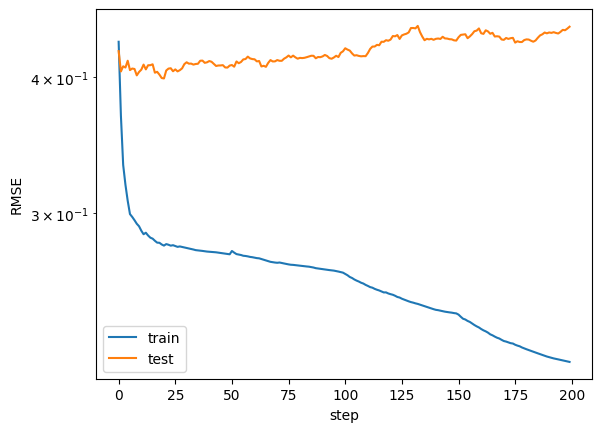

In [201]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

### Pruning

In [ ]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot()

## Interpretability investigation

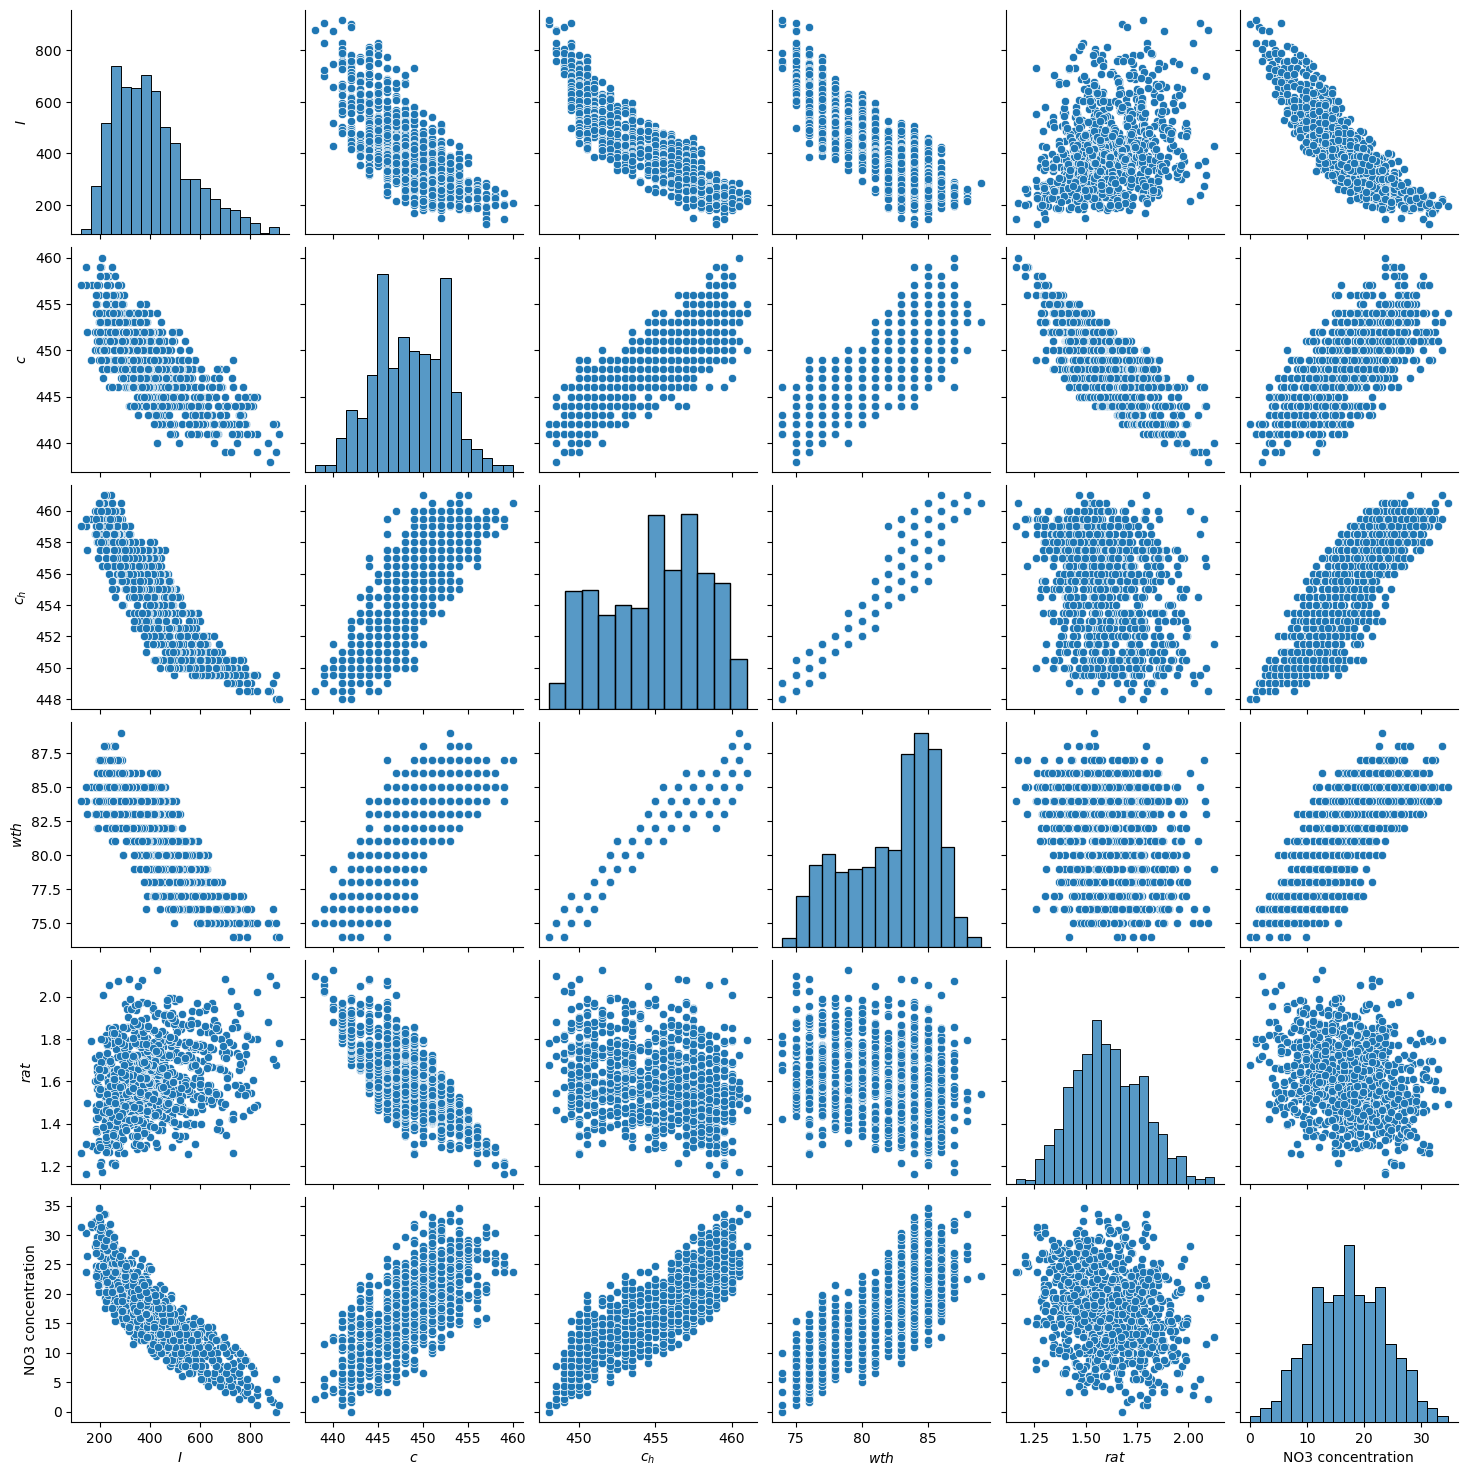

In [125]:
PREDICT_IONS = ['NO3']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']

x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=""+SPEC_FOLDER)
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()
x = get_all_sqz_input(x_matrix, y_matrix)

squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''

tc_x_train = torch.tensor(x_train, dtype=torch.float)
tc_y_train = torch.tensor(y_train.reshape([-1,1]), dtype=torch.float)
tc_x_test = torch.tensor(x_test, dtype=torch.float)
tc_y_test = torch.tensor(y_test.reshape([-1,1]), dtype=torch.float)

dataset = {'train_input': tc_x_train,
           'train_label': tc_y_train,
           'test_input': tc_x_test,
           'test_label': tc_y_test}

INPUT_SHAPE = tc_x_train.shape[1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.97e+00 | test_loss: 2.92e+00 | reg: 1.65e+01 | : 100%|█| 20/20 [00:04<00:00,  4.26it


saving model version 0.1


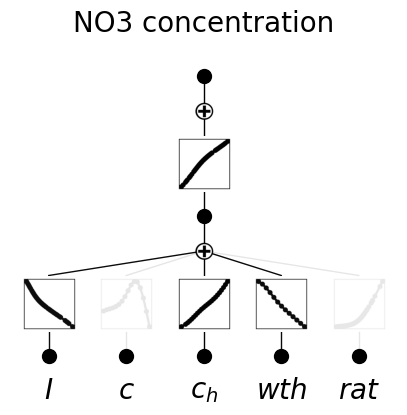

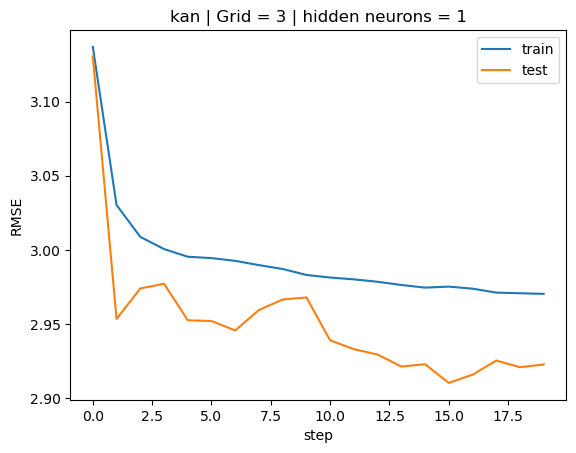

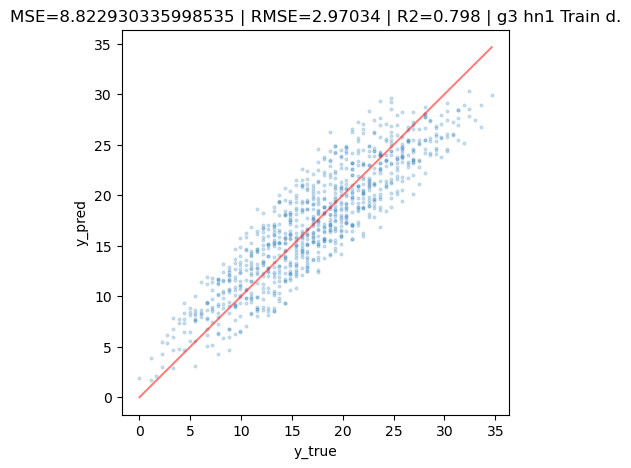

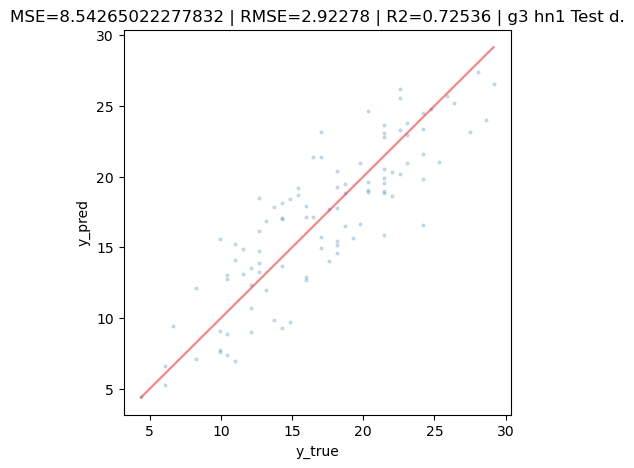

(8.542653, 0.7253636121749878)

In [133]:
model2 = KAN(width=[INPUT_SHAPE, 1, 1], seed=5, grid=3, k=3)


result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2
                       )


VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
INPUT_SHAPE = tc_x_test.shape[1]
prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample':True }
model2.plot(**prnt_kwrgs)
plt.show()


plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()


scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      x^2    0.997415 -8.589954           2                2   -0.117991
1        0    0.000000  0.000014           0                0    0.000003
2      cos    0.992146 -6.990480           2                2    0.201904
3      sin    0.992146 -6.990458           2                2    0.201908
4        x    0.815302 -2.436680           1                1    0.312664


('x^2',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9974148273468018,
 2)

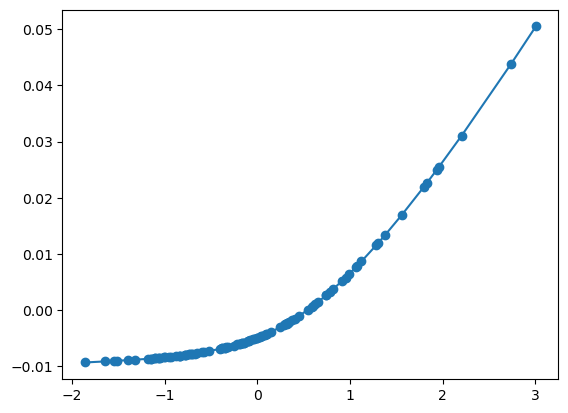

In [135]:
l = 0#1
i = 4#0
j = 0#0

inputs = model2.spline_preacts[l][:,j,i]
outputs = model2.spline_postacts[l][:,j,i]
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

model2.suggest_symbolic(l,i,j)

In [137]:
l = 0#1
i = 4#0
j = 0#0

model2.fix_symbolic(l,i,j,'0',fit_params_bool=True)
model2(dataset['train_input'])

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


tensor([[14.0691],
        [ 2.8435],
        [18.7249],
        [26.7217],
        [12.4337],
        [23.5050],
        [12.5847],
        [12.3338],
        [18.3772],
        [24.1781],
        [22.1421],
        [23.7390],
        [15.5482],
        [16.2144],
        [24.0081],
        [16.3775],
        [28.2385],
        [12.6805],
        [11.4874],
        [23.0201],
        [13.0839],
        [16.9624],
        [14.9092],
        [15.8237],
        [18.6404],
        [27.1876],
        [11.6935],
        [10.7997],
        [ 9.2719],
        [ 6.3916],
        [24.8217],
        [18.5234],
        [18.2132],
        [23.9874],
        [18.1313],
        [ 9.0688],
        [29.1488],
        [19.2527],
        [12.6515],
        [24.0326],
        [16.4199],
        [23.9692],
        [17.6062],
        [23.0271],
        [11.7065],
        [11.6394],
        [14.6905],
        [25.4768],
        [18.4421],
        [11.5997],
        [17.8240],
        [17.2399],
        [11.

| train_loss: 2.97e+00 | test_loss: 2.90e+00 | reg: 1.65e+01 | : 100%|█| 20/20 [00:06<00:00,  3.33it

saving model version 0.4


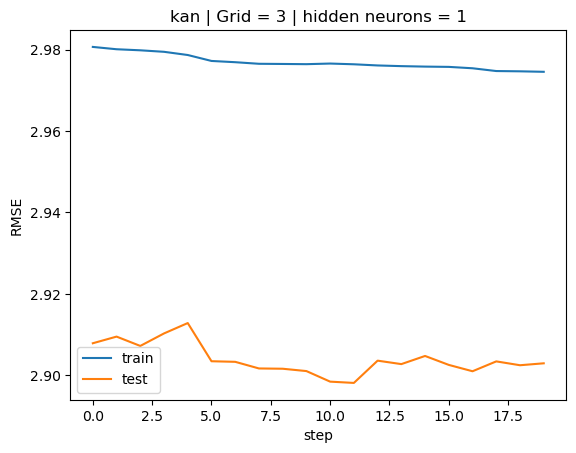

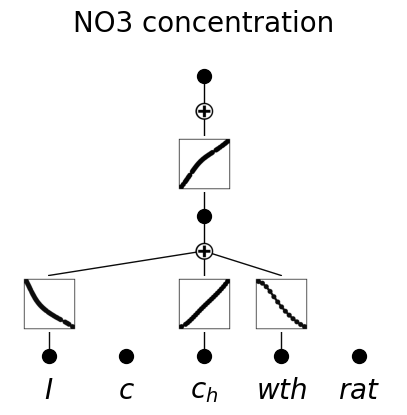

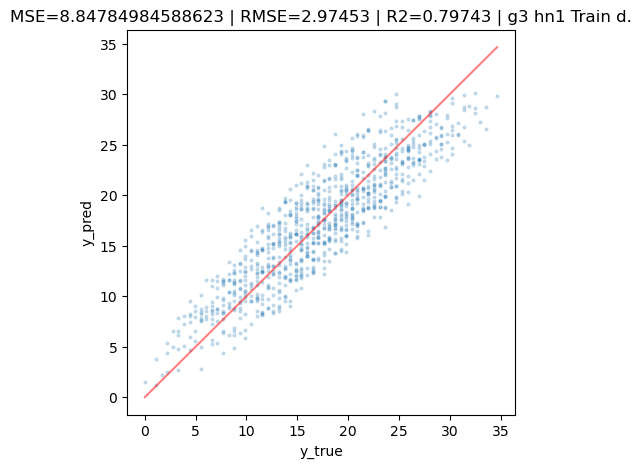

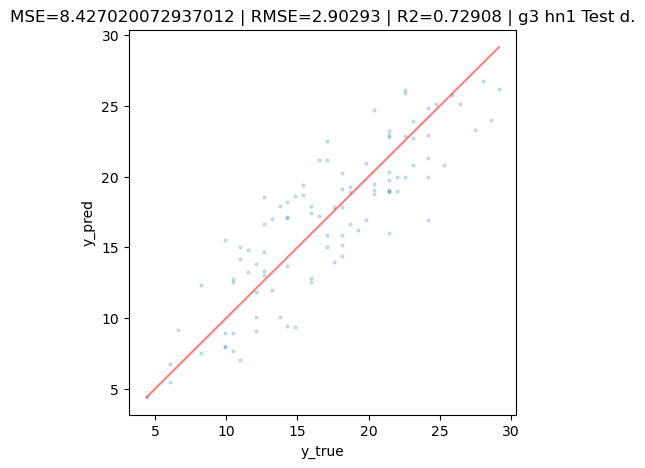

(8.427023, 0.7290809750556946)

In [138]:
result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()


model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

saving model version 0.15


| train_loss: 3.27e-01 | test_loss: 3.06e-01 | reg: 9.44e+00 | : 100%|█| 20/20 [00:07<00:00,  2.55it

saving model version 0.16


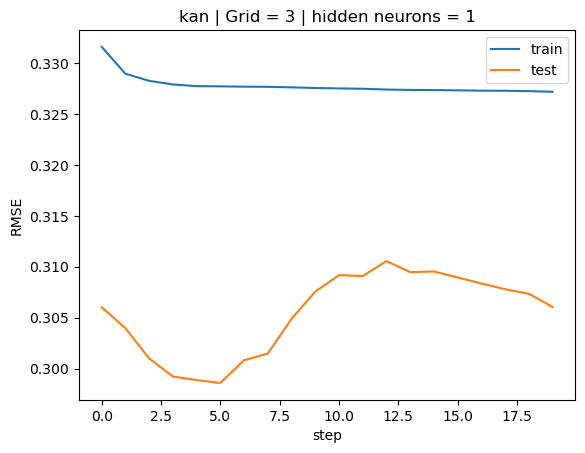

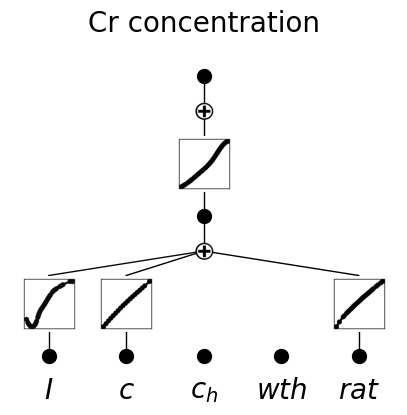

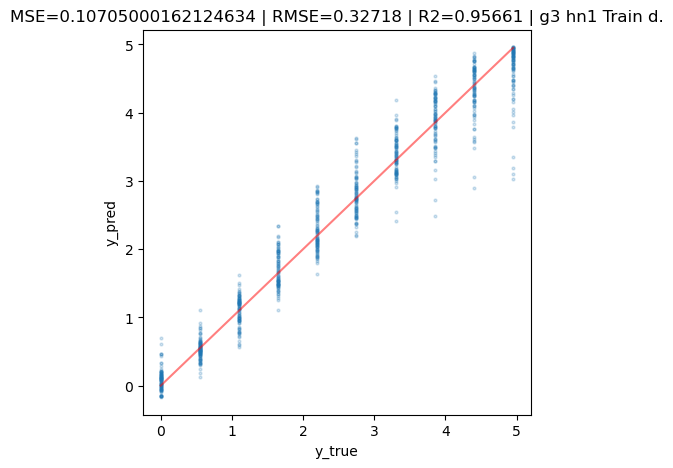

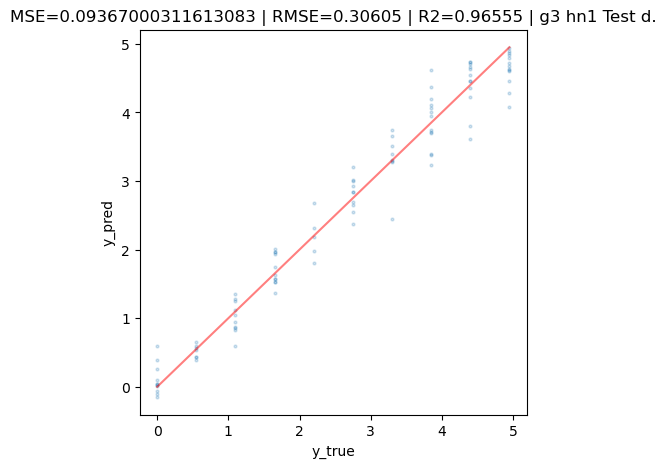

(0.093668945, 0.9655470252037048)

In [73]:
model2 = model2.refine(7)

result2 = model2.fit(dataset, opt="LBFGS", steps=20, 
                       lamb=1e-3,
                       lamb_l1=1,
                       lamb_entropy=2
                       )

plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()


model2.plot(**prnt_kwrgs)

scatter_prediction_kan(model2, tc_x_train, tc_y_train, "g3 hn1 Train d.")
scatter_prediction_kan(model2, tc_x_test, tc_y_test, "g3 hn1 Test d.")

# Energy instead length

Get wavelength transfer them from [nm] to energy [eV] according to formula:
$$ E=\frac{hc}{\lambda}=\frac{6.62607*2.99792}{1.60218}*10^{2}*\frac{1}{\lambda}  eV$$ 

In [152]:
l_wavelenth = get_wavelength(spec_file=""+SPEC_FOLDER)
l_energ = 6.62607*2.99792/1.60218*10**2 / l_wavelenth

In [350]:
plotly_multi_scatter([(l_wavelenth, x.loc[x.index[0]].values),
                      (l_wavelenth, x.loc[x.index[1]].values),
                      (l_wavelenth, x.loc[x.index[3]].values)], 
                     main_title="Спектры флуоресценции на длине волны возбуждения 350 нм", x_title="k, nm", y_title="Интенсивность")

[251. 252. 253. 254. 255.] [2.358 2.249 0.788 2.067 2.199]
[251. 252. 253. 254. 255.] [5.769 3.68  4.35  5.62  3.09 ]
[251. 252. 253. 254. 255.] [3.075 2.551 1.681 1.908 2.565]


In [154]:
plotly_multi_scatter([(l_energ, x.loc[x.index[0]].values),
                      (l_energ, x.loc[x.index[1]].values),
                      (l_energ, x.loc[x.index[-1]].values)], 
                     main_title="FL on 350 nm excitation", x_title="Energy, eV", y_title="Intensity")

[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [2.358 2.249 0.788 2.067 2.199]
[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [5.769 3.68  4.35  5.62  3.09 ]
[4.93959146 4.91998991 4.90054331 4.88124983 4.86210768] [3.151 2.479 2.284 3.149 2.345]
